- change location of connecting question dataframe
- add listening and reading part info

In [1]:
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null 2>&1

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
import riiideducation

_ = np.seterr(divide='ignore', invalid='ignore')

# Preprocess

In [3]:
data_types_dict = {
    'user_id': 'int32', 
    'content_id': 'int16', 
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

In [4]:
train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv', columns=set(data_types_dict.keys())).to_pandas()
train_df = train_df[train_df[target] != -1].reset_index(drop=True)
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df.astype(data_types_dict)

In [5]:
questions_df = pd.read_csv(
    '../input/riiid-test-answer-prediction/questions.csv', 
    usecols=[0, 3],
    dtype={'question_id': 'int16', 'part': 'int8'}
)
train_df = pd.merge(train_df, questions_df, left_on='content_id', right_on='question_id', how='left')
train_df.drop(columns=['question_id'], inplace=True)

In [6]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()
cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)
del cum

In [7]:
train_df["reading_part"] = train_df["part"] >=5
train_df["reading_part"] = train_df["reading_part"].astype("int8")
train_df['reading_part_lag'] = train_df.groupby('user_id')["reading_part"].shift()
cum = train_df.groupby('user_id')['reading_part_lag'].agg(['cumsum']) 
train_df['reading_part_ratio'] = cum['cumsum'] 
train_df.drop(columns=['reading_part_lag', 'reading_part'], inplace=True)
del cum

In [8]:
train_df["listening_part"] = (train_df["part"] >=1) | (train_df["part"] <=4)
train_df["listening_part"] = train_df["listening_part"].astype("int8")
train_df['listening_part_lag'] = train_df.groupby('user_id')["listening_part"].shift()
cum = train_df.groupby('user_id')['listening_part_lag'].agg(['cumsum']) 
train_df['listening_part_ratio'] = cum['cumsum'] 
train_df.drop(columns=['listening_part_lag', 'listening_part'], inplace=True)
del cum

In [9]:
user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count'])

In [10]:
user_listening_agg = train_df.groupby('user_id')["listening_part_ratio"].agg(['max'])
user_reading_agg = train_df.groupby('user_id')["reading_part_ratio"].agg(['max'])

In [11]:
train_df["count"] = 1
train_df["count"] = train_df.groupby("user_id")["count"].cumsum()

In [12]:
train_df = train_df.groupby('user_id').tail(24).reset_index(drop=True)

In [13]:
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_id'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])

In [14]:
valid_df = train_df.groupby('user_id').tail(6)
train_df.drop(valid_df.index, inplace=True)

In [15]:
train_df.head()

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,part,user_correctness,reading_part_ratio,listening_part_ratio,count,content_count
0,115,0.687217,0,19000.0,False,1,0.727273,2.0,22.0,23,36674
1,115,0.608222,0,21000.0,False,1,0.695652,2.0,23.0,24,47047
2,115,0.601824,1,22000.0,False,1,0.666667,2.0,24.0,25,40452
3,115,0.418436,1,16000.0,False,1,0.680000,2.0,25.0,26,190170
4,115,0.474545,1,20000.0,False,1,0.692308,2.0,26.0,27,56707


# Train

In [16]:
features = [
    'content_id',
    'prior_question_elapsed_time',
    'prior_question_had_explanation',
    'user_correctness',
    'part',
    'content_count',
    'count',
    'reading_part_ratio',
    'listening_part_ratio'
]

params = {
    'objective': 'binary',
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_bin': 800,
    'num_leaves': 80
}

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.752806	valid_1's auc: 0.735184
[100]	training's auc: 0.754888	valid_1's auc: 0.737543
[150]	training's auc: 0.75587	valid_1's auc: 0.738501
[200]	training's auc: 0.756302	valid_1's auc: 0.738763
[250]	training's auc: 0.756631	valid_1's auc: 0.738935
[300]	training's auc: 0.756957	valid_1's auc: 0.73909
[350]	training's auc: 0.757241	valid_1's auc: 0.739191
[400]	training's auc: 0.757532	valid_1's auc: 0.739299
[450]	training's auc: 0.757815	valid_1's auc: 0.739422
[500]	training's auc: 0.758081	valid_1's auc: 0.739531
[550]	training's auc: 0.758321	valid_1's auc: 0.739589
[600]	training's auc: 0.758552	valid_1's auc: 0.739656
[650]	training's auc: 0.758776	valid_1's auc: 0.739707
[700]	training's auc: 0.758982	valid_1's auc: 0.739764
[750]	training's auc: 0.75921	valid_1's auc: 0.739829
[800]	training's auc: 0.759411	valid_1's auc: 0.739866
[850]	training's auc: 0.759617	valid_1's auc: 0.739921
[900]	tr

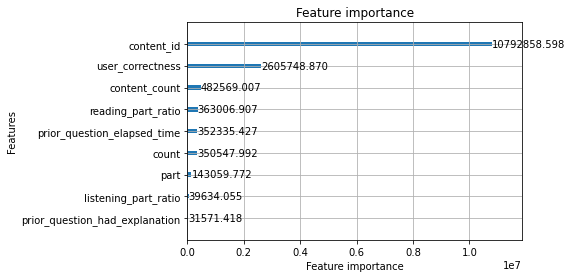

In [17]:
tr_data = lgb.Dataset(train_df[features], label=train_df[target])
va_data = lgb.Dataset(valid_df[features], label=valid_df[target])

model = lgb.train(
    params, 
    tr_data, 
    num_boost_round=10000,
    valid_sets=[tr_data, va_data], 
    early_stopping_rounds=50,
    verbose_eval=50
)

# model.save_model(f'model.txt')
lgb.plot_importance(model, importance_type='gain')
plt.show()

# Inference

In [18]:
user_reading_agg['max'].fillna(0,inplace=True)
user_listening_agg['max'].fillna(0,inplace=True)

In [19]:
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))
user_reading_dict = user_reading_agg['max'].astype('int32').to_dict(defaultdict(int))
user_listening_dict = user_listening_agg['max'].astype('int32').to_dict(defaultdict(int))

In [20]:
# model = lgb.Booster(model_file='../input/riiid-lgbm-starter/model.txt')
env = riiideducation.make_env()
iter_test = env.iter_test()
prior_test_df = None

In [21]:
%%time

for (test_df, sample_prediction_df) in iter_test:
    if prior_test_df is not None:
        prior_test_df[target] = eval(test_df['prior_group_answers_correct'].iloc[0])
        prior_test_df = prior_test_df[prior_test_df[target] != -1].reset_index(drop=True)
        
        user_ids = prior_test_df['user_id'].values
        content_ids = prior_test_df['content_id'].values
        targets = prior_test_df[target].values
        parts = prior_part_arrays
        
        for user_id, content_id, answered_correctly, part in zip(user_ids, content_ids, targets, parts):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1
            content_sum_dict[content_id] += answered_correctly
            content_count_dict[content_id] += 1
            if part <=4:
                user_listening_dict[user_id] +=1
            else:
                user_reading_dict[user_id] +=1

    prior_test_df = test_df.copy()
    
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    test_df = pd.merge(test_df, questions_df, left_on='content_id', right_on='question_id', how='left')
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(False).astype('bool')    
    
    prior_part_arrays = test_df['part'].values
    
    user_sum = np.zeros(len(test_df), dtype=np.int16)
    user_count = np.zeros(len(test_df), dtype=np.int16)
    content_sum = np.zeros(len(test_df), dtype=np.int32)
    content_count = np.zeros(len(test_df), dtype=np.int32)
    listening_count = np.zeros(len(test_df), dtype=np.int32)
    reading_count = np.zeros(len(test_df), dtype=np.int32)
    
    for i, (user_id, content_id) in enumerate(zip(test_df['user_id'].values, test_df['content_id'].values)):
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]
        listening_count[i] = user_listening_dict[user_id]
        reading_count[i] = user_reading_dict[user_id]

    test_df['user_correctness'] = user_sum / user_count
    test_df['content_count'] = content_count
    test_df['content_id'] = content_sum / content_count
    test_df['count'] = 1
    test_df['count'] = test_df.groupby("user_id")["count"].cumsum()
    test_df['count'] += user_count
    test_df['reading_part_ratio'] = reading_count
    test_df['listening_part_ratio'] = listening_count
    
    test_df[target] = model.predict(test_df[features])
    env.predict(test_df[['row_id', target]])

CPU times: user 1.23 s, sys: 81 ms, total: 1.31 s
Wall time: 814 ms
